This is a sample to understand the basics of Pyro. 
Our model will be very simple: we want to infer the bias of a coin after seeing a particular sequence of heads/tails results. We'll use $\text{Uniform}(0, 1)$ as the prior for the bias. 

In [ ]:
%pip install pyro-ppl 

In [15]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch

data = [0, 1, 1, 0, 0, 0, 1, 0, 1, 0] # Sample data - 4 ones and 6 zeros 

def model(data):
    bias = pyro.sample("bias", dist.Uniform(0, 1)) # Our bias prior 
    for index, observation in enumerate(data):
        pyro.sample(f"observation_{index}", dist.Bernoulli(bias), obs=torch.tensor(float(observation))) # Feed our data into the model


Now, we need a _guide_ function. This is essentially a probability distribution that will be used to approximate the posterior. In this case, since we'll use the SVI (**S**tochastic **V**ariotional **I**nference) algorithm, this will be the function used in the variotinal procedure, in which we seek to tweak the parameters of the guide function in order to minimize the "surprise" brought up by the observations.

As our guide, we'll use the beta distribution, which is characterized by two parameters: $\alpha$ and $\beta$. We'll contrain both of them to be positive. Note that Pyro requires the guide and model to have the same signatures, even if not all of the arguments are used in either function.

**Important**: all numerical inputs that will be directly used by the optimizer need to be torch tensors (`torch.tensor`), as opposed to simple Python types, as the data types must be consistent, so we convert them to floats since the parameters are allowed to be floats.

In [16]:
import torch.distributions.constraints as constraints

def guide(data):
    alpha = pyro.param("alpha", torch.tensor(5.), constraint=constraints.positive)
    beta = pyro.param("beta", torch.tensor(5.), constraint=constraints.positive)
    pyro.sample("bias", dist.Beta(alpha, beta))

The next step will be to approximate the posterior. As mentioned before, we'll do this by using SVI with a SGD optimizer. We'll create a function called `learn` that will run `n_steps` iterations of the SVI/SGD algorithm, while keeping track of the values of the loss, as well as the parameters `alpha` and `beta`. We expect the loss to decrease as we go, and the parameters to, hopefully, converge towards some reasonable value given our data.

In [6]:
def learn(data, n_steps):
    svi = pyro.infer.SVI(
        model=model,
        guide=guide,
        optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
        loss=pyro.infer.Trace_ELBO()
    )    
    alphas, betas, losses = [], [], [] 
    for _ in range(n_steps):
        losses.append(svi.step(data))
        alphas.append(pyro.param("alpha").item())
        betas.append(pyro.param("beta").item())

    return alphas, betas, losses

We now have all the pieces that we need to perform the inference. We'll run 2000 steps and plot the behaviour of the loss and of the parameters as a function of the step number.

In [17]:
alphas, betas, losses = learn(data, 2000)

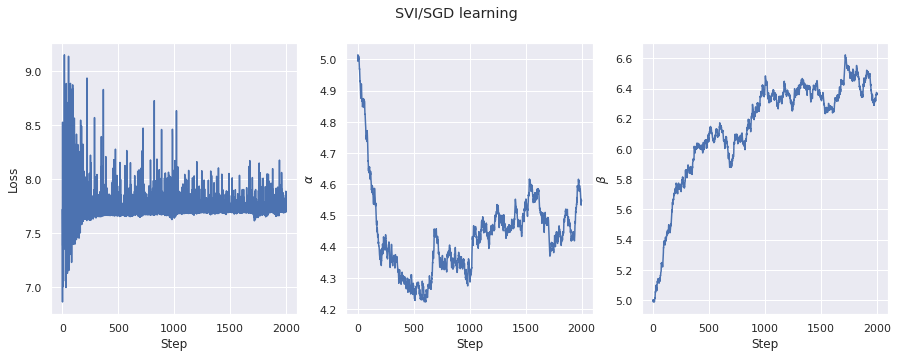

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

fig, axes = plt.subplots(1, 3,  figsize=(15, 5))

plt.suptitle("SVI/SGD learning")


axes[0].plot(losses)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Step")
axes[1].plot(alphas)
axes[1].set_ylabel(r"$\alpha$")
axes[1].set_xlabel("Step")
axes[2].plot(betas)
axes[2].set_ylabel(r"$\beta$")
axes[2].set_xlabel("Step")

plt.show()

Even though our loss didn't really converge towards zer - it's not entirely clear why - the $\alpha$ and $\beta$ parameters do seem to have improved towards a better estimate than their initial values. To see this, we can plot the probability distribution for the bias (which is, ultimately, our posterior) by sampling from a Beta distribution using the last estimates for $\alpha$ and $\beta$:

Mean: 0.4170098602771759
Std: 0.1428743600845337


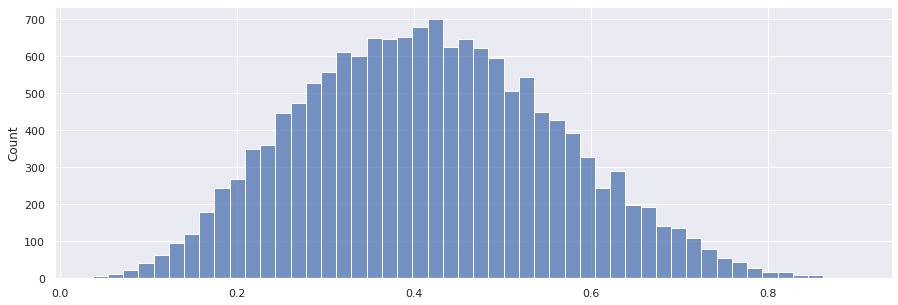

In [53]:
posterior = dist.Beta(alphas[-1], betas[-1])
print(f"Mean: {posterior.mean}")
print(f"Std: {posterior.variance**0.5}")

samples = posterior.rsample((15000, 1)) # The argument to rsample is the shape of samples we want
samples = samples.detach().cpu().numpy() # Transform to a numpy array
samples = samples.flatten() # Transform from a 2D array of samples to a single list of values
plt.figure(figsize=(15, 5))
sns.histplot(samples, bins=50)
plt.show()

We see that the distribution and, in particular, its mean, are pretty close to what we would expect. The sample mean is pretty close to the data mean, which is $0.4$. The probability distribution is also biased towards 0.4, but not too much since our dataset is pretty small.  